<b>Summary: </b>Predicting gender from names using character level RNN

<b>Datasets: </b>https://www.kaggle.com/nltkdata/names , http://www.cs.cmu.edu/afs/cs/project/ai-repository/ai/areas/nlp/corpora/names/

<b>ref: </b>https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

In [1]:
import pandas as pd

In [2]:
names_data = pd.read_csv('names.csv')

In [3]:
names_data.head()

,Name,Gender
0,Aamir,Male
1,Aaron,Female
2,Aaron,Male
3,Abagael,Female
4,Abagail,Female


In [4]:
len(names_data)

10132

In [5]:
len(names_data['Name'].unique())

9543

In [6]:
#Removing duplicate

import random

names_data = names_data.drop_duplicates(subset=['Name'], 
                                       keep=random.choice(['first', 'last']))

len(names_data)

9543

In [7]:
names_data.head()

,Name,Gender
0,Aamir,Male
2,Aaron,Male
3,Abagael,Female
4,Abagail,Female
5,Abbe,Female


In [8]:
#label ncoding gender column

from sklearn import preprocessing

le = preprocessing.LabelEncoder()

names_data['Gender'] = le.fit_transform(names_data['Gender'])

names_data.head()


,Name,Gender
0,Aamir,1
2,Aaron,1
3,Abagael,0
4,Abagail,0
5,Abbe,0


In [9]:
genders = ['Female','Male']

In [10]:
import string

In [11]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [12]:
import torch

def name_to_tensor(name):
    name_in_tensor = torch.zeros(len(name), 1, n_letters)
    for i, letter in enumerate(name):
        name_in_tensor[i][0][all_letters.find(letter)] = 1
    
    return name_in_tensor

In [13]:
name_to_tensor('g')

tensor([[[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]])

In [14]:
name_to_tensor('Hi')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]])

In [15]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    

In [16]:
n_hidden = 128
n_genders = len(genders)


rnn = RNN(n_letters, n_hidden, output_size = n_genders)

In [17]:
iterations = 100000

criterion = nn.NLLLoss()

learning_rate = 0.001

In [18]:
def output_to_gender(output):
    
    top_n,  top_index = output.topk(1)
    pred_i = top_index[0].item()
    pred = genders[pred_i]
    
    return pred

In [19]:
for iteration in range(1, iterations + 1):
    
    i = random.randint(0, len(names_data) - 1)
    
    name = names_data.iloc[i][0]
    name_in_tensor = name_to_tensor(name)
    
    gender = names_data.iloc[i][1]
    gender_in_tensor = torch.LongTensor([gender])
    
    hidden = rnn.initHidden()
    rnn.zero_grad()
    
    for i in range(name_in_tensor.size()[0]):
        output, hidden = rnn(name_in_tensor[i], hidden)
        
    loss = criterion(output, gender_in_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
        
    if iteration % 5000 == 0:
        
        pred = output_to_gender(output)
        
        correct = '✓' if pred == genders[gender] else '✗ {}'.format(genders[gender])
        print('iters - %d %d%% (%s) Name- %s Gender- %s %s' % \
             (iteration, iteration/iteration*100, loss.item(), name, pred, correct))

iters - 5000 100% (0.3747001886367798) Name- Billye Gender- Female ✓
iters - 10000 100% (0.2984405755996704) Name- Barbaraanne Gender- Female ✓
iters - 15000 100% (0.10643308609724045) Name- Diena Gender- Female ✓
iters - 20000 100% (0.3176533579826355) Name- Charlsie Gender- Female ✓
iters - 25000 100% (0.5574806928634644) Name- Burl Gender- Male ✓
iters - 30000 100% (0.5355430841445923) Name- Alphonso Gender- Male ✓
iters - 35000 100% (0.03988619148731232) Name- Terina Gender- Female ✓
iters - 40000 100% (0.057929836213588715) Name- Elma Gender- Female ✓
iters - 45000 100% (0.8253225088119507) Name- Daryl Gender- Female ✗ Male
iters - 50000 100% (0.1881261020898819) Name- Celisse Gender- Female ✓
iters - 55000 100% (0.042877260595560074) Name- Bobina Gender- Female ✓
iters - 60000 100% (0.02230917103588581) Name- Guenna Gender- Female ✓
iters - 65000 100% (0.0313858687877655) Name- Delicia Gender- Female ✓
iters - 70000 100% (0.02033446729183197) Name- Sibella Gender- Female ✓
iters 

In [23]:
n_confusion = 10000

prediction = []
actual = []

for _ in range(n_confusion):
    
    i = random.randint(0, len(names_data) - 1)
    
    name = names_data.iloc[i][0]
    name_in_tensor = name_to_tensor(name)
    
    gender_idx = names_data.iloc[i][1]
    gender_in_tensor = torch.LongTensor([gender_idx])
    
    
    hidden = rnn.initHidden()
    
    for j in range(name_in_tensor.size()[0]):
        output, hidden = rnn(name_in_tensor[j], hidden)
        
    pred = output_to_gender(output)
    
    prediction.append(pred)
    actual.append(genders[gender_idx])

In [24]:
!pip install pandas_ml

In [25]:
from pandas_ml import ConfusionMatrix
import numpy as np

In [26]:
np_prediction = np.array(prediction)
np_actual = np.array(actual)

In [28]:
cm = ConfusionMatrix(np.where(np_prediction == 'Female', True, False),
                    np.where(np_actual == 'Female', True, False))

In [29]:
cm

Predicted  False  True  __all__
Actual                         
False       2062   659     2721
True        1285  5994     7279
__all__     3347  6653    10000

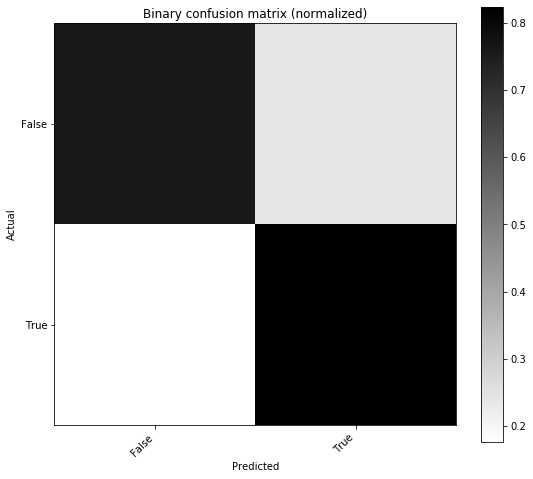

In [30]:
import matplotlib.pyplot as plt
cm.plot(normalized=True)
plt.show()